In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import glob

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
#plt.rcParams['figure.figsize'] = (19.0, 17.0) # set default size of plots
#plt.rcParams['figure.figsize'] = (13.0, 11.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = 'bilalzaidi88'
os.environ['KAGGLE_KEY'] = '8025490c015643f9e503131ed442c8c3'

In [18]:
!kaggle datasets download -d fpeccia/weed-detection-in-soybean-crops

weed-detection-in-soybean-crops.zip: Skipping, found more recently modified local copy (use --force to force download)


In [19]:
#os.chdir('/content/pneumonia')
print(os.listdir())
!unzip -q weed-detection-in-soybean-crops.zip

['.config', 'weed-detection-in-soybean-crops.zip', 'drive', 'sample_data']


In [20]:
#os.chdir('./dataset/broadleaf')
print(os.listdir())

['.config', 'dataset', 'weed-detection-in-soybean-crops.zip', 'drive', 'sample_data']


In [0]:
# delete all files in dataset/broadleaf, dataset/grass, dataset/soil, dataset/soybean
!rm -r ./dataset/broadleaf/*
!rm -r ./dataset/grass/*
!rm -r ./dataset/soil/*
!rm -r ./dataset/soybean/*

## Data augementation ##

Make more trainingsimages with data augementation

In [0]:
class Data_augmentation:
    def __init__(self, path, image_name):
        '''
        Import image
        :param path: Path to the image
        :param image_name: image name
        '''
        self.path = path
        self.name = image_name
        print(path+image_name)
        self.image = cv2.imread(path+image_name)

    def rotate(self, image, angle=90, scale=1.0):
        '''
        Rotate the image
        :param image: image to be processed
        :param angle: Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
        :param scale: Isotropic scale factor.
        '''
        w = image.shape[1]
        h = image.shape[0]
        #rotate matrix
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
        #rotate
        image = cv2.warpAffine(image,M,(w,h))
        return image

    def flip(self, image, vflip=False, hflip=False):
        '''
        Flip the image
        :param image: image to be processed
        :param vflip: whether to flip the image vertically
        :param hflip: whether to flip the image horizontally
        '''
        if hflip or vflip:
            if hflip and vflip:
                c = -1
            else:
                c = 0 if vflip else 1
            image = cv2.flip(image, flipCode=c)
        return image 
    
    
    def image_augment(self, save_path): 
        '''
        Create the new image with imge augmentation
        :param path: the path to store the new image
        ''' 
        img = self.image.copy()
        img_flip = self.flip(img, vflip=True, hflip=False)
        img_rot = self.rotate(img)
        #img_gaussian = self.add_GaussianNoise(img)
        
        name_int = self.name[:len(self.name)-4]
        cv2.imwrite(save_path+'%s' %str(name_int)+'_vflip.jpg', img_flip)
        cv2.imwrite(save_path+'%s' %str(name_int)+'_rot.jpg', img_rot)
        #cv2.imwrite(save_path+'%s' %str(name_int)+'_GaussianNoise.jpg', img_gaussian)

In [0]:
def main(file_dir,output_path):
        for root, _, files in os.walk(file_dir):
            print(root)
        for file in files:
            raw_image = Data_augmentation(root,file)
            raw_image.image_augment(output_path)

In [24]:
file_dir = './dataset/dataset/broadleaf/'
output_path = './dataset/broadleaf/'
main(file_dir=file_dir, output_path=output_path)

file_dir = './dataset/dataset/grass/'
output_path = './dataset/grass/'
main(file_dir=file_dir, output_path=output_path)

file_dir = './dataset/dataset/soil/'
output_path = './dataset/soil/'
main(file_dir=file_dir, output_path=output_path)

file_dir = './dataset/dataset/soybean/'
output_path = './dataset/soybean/'
main(file_dir=file_dir, output_path=output_path)

./dataset/dataset/broadleaf/
./dataset/dataset/broadleaf/181.tif
./dataset/dataset/broadleaf/316.tif
./dataset/dataset/broadleaf/815.tif
./dataset/dataset/broadleaf/520.tif
./dataset/dataset/broadleaf/396.tif
./dataset/dataset/broadleaf/7.tif
./dataset/dataset/broadleaf/433.tif
./dataset/dataset/broadleaf/556.tif
./dataset/dataset/broadleaf/216.tif
./dataset/dataset/broadleaf/62.tif
./dataset/dataset/broadleaf/675.tif
./dataset/dataset/broadleaf/214.tif
./dataset/dataset/broadleaf/533.tif
./dataset/dataset/broadleaf/836.tif
./dataset/dataset/broadleaf/837.tif
./dataset/dataset/broadleaf/70.tif
./dataset/dataset/broadleaf/228.tif
./dataset/dataset/broadleaf/221.tif
./dataset/dataset/broadleaf/561.tif
./dataset/dataset/broadleaf/1186.tif
./dataset/dataset/broadleaf/1070.tif
./dataset/dataset/broadleaf/167.tif
./dataset/dataset/broadleaf/1011.tif
./dataset/dataset/broadleaf/1099.tif
./dataset/dataset/broadleaf/1117.tif
./dataset/dataset/broadleaf/1026.tif
./dataset/dataset/broadleaf/613.t

In [0]:
import matplotlib.pyplot as plt
import cv2
import glob
import numpy as np

In [27]:
data_dir = r'./dataset/dataset/' # Setting the dataset directory
classes = ['broadleaf', 'grass', 'soil', 'soybean'] # Setting all the available classes

num_file = 1100 # Number of files
all_files = []
num_data = num_file * len(classes)
Y = np.zeros(num_data) # Initialize all output values with 0

# Get the files
for i, cls in enumerate(classes):
  all_files += [f for f in glob.glob(data_dir + cls + '/*.tif')][:num_file]
  Y[i * num_file: (i + 1) * num_file] = i # Label all classes with int [0.. len(classes)]

image_width = 200
image_height = 200
image_channel = 3
dimension = image_width * image_height * image_channel

X = np.ndarray(shape=(num_data, image_width, image_height, image_channel), dtype=np.uint8) # Create a nd array

for i, file in enumerate(all_files):
  X[i] = cv2.resize(cv2.imread(file), (image_width, image_height)) # Add and load all images

# Split training, validation and testing set by creating empty arrays
X_train = np.empty(shape=(4000, image_width, image_height, image_channel), dtype=np.uint8)
X_val = np.empty(shape=(200, image_width, image_height, image_channel), dtype=np.uint8)
X_test = np.empty(shape=(200, image_width, image_height, image_channel), dtype=np.uint8)

Y_train = np.empty(4000)
Y_val = np.empty(200)
Y_test = np.empty(200)

# Set all x and y values
for i, cls in enumerate(classes):
  X_test[50 * i: 50 * (i + 1)] = X[np.where(Y == i)[0][:50]]
  X_val[50 * i: 50 * (i + 1)] = X[np.where(Y == i)[0][50:100]]
  X_train[1000 * i: 1000 * (i + 1)] = X[np.where(Y == i)[0][100:]]

  Y_test[50 * i: 50 * (i + 1)] = i
  Y_val[50 * i: 50 * (i + 1)] = i
  Y_train[1000 * i: 1000 * (i + 1)] = i

# Save some memory by deleting X and Y
del Y
del X

# Select random x and y train data
train_indexes = np.random.permutation(X_train.shape[0]) # Create random indexes array with the length of X_train.shape[0]
Y_train = Y_train[train_indexes].astype(int) 
X_train = X_train[train_indexes]

# Reshape the train, test, val data
X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')
X_val = np.reshape(X_val, (X_val.shape[0], -1)).astype('float64')

# Create custom tiny dataset for testing
X_tiny = X_train[100:110].astype('float64')
Y_tiny = Y_train[100:110].astype(int)
num_dev = 500

# Create custom dev dataset for testing
X_dev = X_train[0:num_dev].astype('float64')
Y_dev = Y_train[0:num_dev].astype(int)

# Compute the mean image
mean_image = np.mean(X_train, axis=0) # axis=0. stack horizontally
# Subtract the mean image from train and test data 
X_train -= mean_image
X_val -= mean_image 
X_test -= mean_image
X_dev -= mean_image
X_tiny -= mean_image

print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("X_val shape", X_val.shape)
print("X_dev shape", X_dev.shape)
print("X_tiny shape", X_tiny.shape)

X_train shape (4000, 120000)
X_test shape (200, 120000)
X_val shape (200, 120000)
X_dev shape (500, 120000)
X_tiny shape (10, 120000)


In [0]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

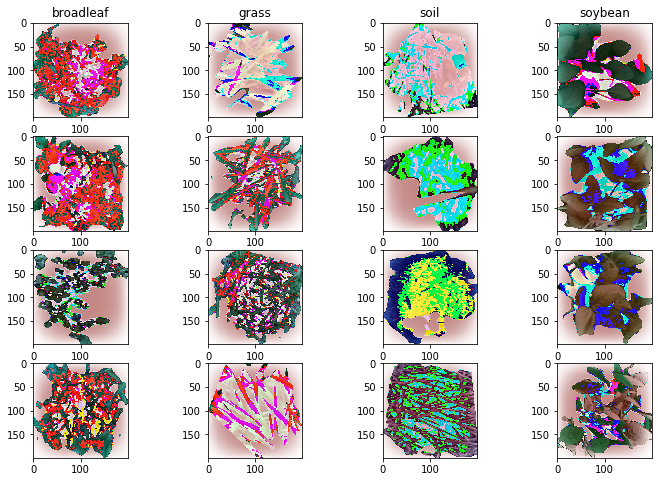

In [29]:
classes = ['broadleaf', 'grass', 'soil', 'soybean']
n_class = len(classes)
samples_per_class = 4

# Plot 4 images of each class
for Y, cls in enumerate(classes):
  indexes = np.flatnonzero(Y == Y_train)
  indexes = np.random.choice(indexes, samples_per_class, replace=False)
  for i, index, in enumerate(indexes):
    plt_index = i * n_class + Y + 1
    plt.subplot(samples_per_class, n_class, plt_index)
    plt.imshow(X_train[index].reshape(image_width, image_height, image_channel).astype('uint8'))
    if i == 0: plt.title(cls)

plt.show()

In [0]:
class NeuralNetwork:
  hidden_size = 200
  input_size = image_width * image_height * image_channel
  output_size = n_class

  """
  w1: first layer weight
  w2: second layer weight
  """
  w1 = 1e-3 * np.random.randn(input_size, hidden_size)
  b1 = np.zeros(hidden_size)
  w2 = 1e-3 * np.random.randn(hidden_size, output_size)
  b2 = np.zeros(output_size)
    
  alpha = 1e-5
  batch_size = 100
    
  epochs = 500
  
  def train(self, X, Y, X_val, Y_val):
    N, D = X.shape
    N_val = X_val.shape[0]
    iteration_per_epoch = max(N / self.batch_size, 1)

    loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    
    for it in range(self.epochs):
      sampling = np.random.choice(np.arange(N), self.batch_size, replace=False) # Create random array data

      # Getting batches for x and y
      X_batch = X[sampling]
      Y_batch = Y[sampling]

      loss, grads = self.loss(X_batch, Y=Y_batch)
      loss_hist.append(loss)

      # Make the model learning and reshape the parameters of the network
      self.w1 += -1.0 * self.alpha * grads['w1']
      self.b1 += -1.0 * self.alpha * grads['b1']
      self.w2 += -1.0 * self.alpha * grads['w2']
      self.b2 += -1.0 * self.alpha * grads['b2']

      if it % 10 == 0:
        print('iteration: %d / %d | Loss: %f' % (it, self.epochs, loss))
    
      if it % iteration_per_epoch == 0:
        train_acc = (self.predict(X_batch) == Y_batch).mean()
        val_acc = (self.predict(X_val) == Y_val).mean()
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        self.alpha *= 0.95
    
    return {
        'loss_hist': loss_hist,
        'train_acc_hist': train_acc_hist,
        'val_acc_hist': val_acc_hist
    }

  def relu(self, z):
    return np.maximum(0, z)
  
  def predict(self, X):
    Y_pred = None
    layer1 = self.relu(X.dot(self.w1) + self.b1)
    scores = layer1.dot(self.w2) + self.b2
    Y_pred = np.argmax(scores, axis=1)
    return Y_pred

  def loss(self, X, Y = None):
    N, D = X.shape

    # Calculate the loss of our layer1
    layer1 = self.relu(X.dot(self.w1) + self.b1)
    scores = layer1.dot(self.w2) + self.b2

    if (Y is None):
      return scores

    # Calculate the actual loss
    scores -= scores.max()
    scores = np.exp(scores)
    scores_sumexp = np.sum(scores, axis=1)
    softmax = scores / scores_sumexp.reshape(N, 1)
    loss = -1.0 * np.sum(np.log(softmax[range(N), Y]))
    loss /= N

    grads = {}
    correct_class_scores = scores[range(N), Y]
    softmax[range(N), Y] = -1.0 * (scores_sumexp - correct_class_scores) / scores_sumexp
    softmax /= N

    grads['w2'] = layer1.T.dot(softmax)
    grads['b2'] = np.sum(softmax, axis=0)

    hidden = softmax.dot(self.w2.T)

    grads['w1'] = X.T.dot(hidden)
    grads['b1'] = np.sum(hidden, axis=0)

    return loss, grads

In [31]:
nn = NeuralNetwork()
stats = nn.train(X_dev, Y_dev, X_val, Y_val)

iteration: 0 / 500 | Loss: 1.398829
iteration: 10 / 500 | Loss: 1.352635
iteration: 20 / 500 | Loss: 1.307768
iteration: 30 / 500 | Loss: 1.255728
iteration: 40 / 500 | Loss: 1.202566
iteration: 50 / 500 | Loss: 1.173135
iteration: 60 / 500 | Loss: 1.196833
iteration: 70 / 500 | Loss: 1.187448
iteration: 80 / 500 | Loss: 1.128868
iteration: 90 / 500 | Loss: 1.098550
iteration: 100 / 500 | Loss: 1.081422
iteration: 110 / 500 | Loss: 1.083952
iteration: 120 / 500 | Loss: 1.079392
iteration: 130 / 500 | Loss: 1.054538
iteration: 140 / 500 | Loss: 1.069860
iteration: 150 / 500 | Loss: 1.006936
iteration: 160 / 500 | Loss: 0.975729
iteration: 170 / 500 | Loss: 1.025102
iteration: 180 / 500 | Loss: 1.033500
iteration: 190 / 500 | Loss: 1.003772
iteration: 200 / 500 | Loss: 1.020024
iteration: 210 / 500 | Loss: 0.985156
iteration: 220 / 500 | Loss: 0.955920
iteration: 230 / 500 | Loss: 1.013097
iteration: 240 / 500 | Loss: 0.972626
iteration: 250 / 500 | Loss: 1.019264
iteration: 260 / 500 | 

In [32]:
print((nn.predict(X_test) == Y_test).mean())

0.715


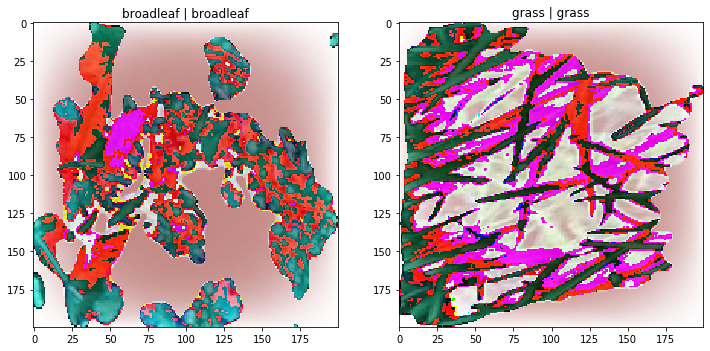

In [33]:
index = np.flatnonzero(0 == Y_train)
index = np.random.choice(index, 1, replace=False)
prediction = nn.predict(X_train[index])

plt.subplot(1, 2, 1)
plt.title('{} | {}'.format(classes[0], classes[prediction[0]]))
plt.imshow(X_train[index].reshape(image_width, image_height, image_channel).astype('uint8'))

index = np.flatnonzero(1 == Y_train)
index = np.random.choice(index, 1, replace=False)
prediction = nn.predict(X_train[index])

plt.subplot(1, 2, 2)
plt.title('{} | {}'.format(classes[1], classes[prediction[0]]))
plt.imshow(X_train[index].reshape(image_width, image_height, image_channel).astype('uint8'))